In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kushagrakinjawadekar/game-of-thrones-character-classification

game-of-thrones-character-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import zipfile
from io import BytesIO

In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return img_array

In [ ]:
zip_file_path = '/content/game-of-thrones-character-classification.zip'

labels_dict = {}
X = []
y = []

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if file_info.filename.startswith('dataset/Test'):
            class_name = file_info.filename.split('/')[2]
            labels_dict[file_info.filename] = class_name

            image_path = BytesIO(zip_ref.read(file_info.filename))
            img = preprocess_image(image_path)

            X.append(img)
            y.append(class_name)

image_df = pd.DataFrame({'file_path': [file_info.filename for file_info in zip_ref.infolist() if file_info.filename.startswith('dataset/Test')],
                         'label': [labels_dict[file_info.filename] for file_info in zip_ref.infolist() if file_info.filename.startswith('dataset/Test')]})

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded, num_classes=6)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_6 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_7 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                      

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
11/11 [==============================] - 69s 6s/step - loss: 1.2165 - accuracy: 0.8308 - val_loss: 9.0499 - val_accuracy: 0.2805
Epoch 2/10
11/11 [==============================] - 61s 6s/step - loss: 1.0958 - accuracy: 0.8431 - val_loss: 19.4225 - val_accuracy: 0.1463
Epoch 3/10
11/11 [==============================] - 59s 5s/step - loss: 1.2024 - accuracy: 0.8185 - val_loss: 17.6068 - val_accuracy: 0.1220
Epoch 4/10
11/11 [==============================] - 60s 5s/step - loss: 1.3130 - accuracy: 0.8462 - val_loss: 19.5611 - val_accuracy: 0.1220
Epoch 5/10
11/11 [==============================] - 60s 5s/step - loss: 1.0518 - accuracy: 0.8831 - val_loss: 15.4749 - val_accuracy: 0.1341
Epoch 6/10
11/11 [==============================] - 60s 5s/step - loss: 0.7514 - accuracy: 0.9015 - val_loss: 6.4889 - val_accuracy: 0.1951
Epoch 7/10
11/11 [==============================] - 61s 5s/step - loss: 1.2391 - accuracy: 0.8708 - val_loss: 5.4672 - val_accuracy: 0.2195
Epoch 8/10
11/11

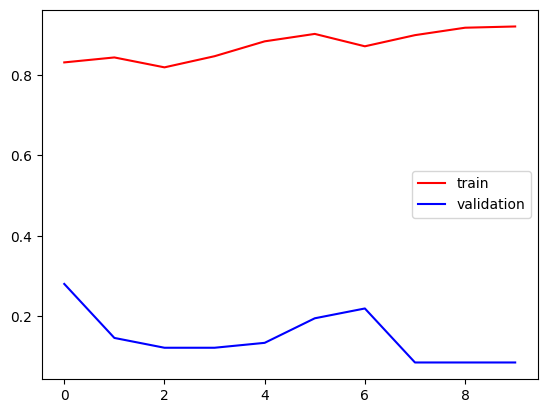

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
import cv2

1/1 [==============================] - 0s 61ms/step


array([[0., 0., 1., 0., 0., 0.]], dtype=float32)

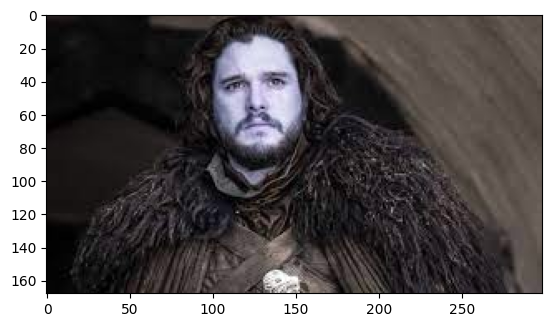

In [ ]:
test_img = cv2.imread('/content/snow.jpeg')
plt.imshow(test_img)
test_img.shape
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))
model.predict(test_input)

In [ ]:
predicted_class_index = np.argmax(model.predict(test_input), axis=-1)
predicted_class_name = label_encoder.classes_[predicted_class_index[0]]
print(predicted_class_name)

1/1 [==============================] - 0s 70ms/step
Predicted class: Jaime Lannister


In [ ]:
history2 = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
11/11 [==============================] - 62s 6s/step - loss: 0.5293 - accuracy: 0.9354 - val_loss: 27.2662 - val_accuracy: 0.1098
Epoch 2/30
11/11 [==============================] - 58s 5s/step - loss: 0.6552 - accuracy: 0.9262 - val_loss: 14.6073 - val_accuracy: 0.1951
Epoch 3/30
11/11 [==============================] - 57s 5s/step - loss: 0.5003 - accuracy: 0.9385 - val_loss: 7.8246 - val_accuracy: 0.2317
Epoch 4/30
11/11 [==============================] - 58s 5s/step - loss: 0.3266 - accuracy: 0.9508 - val_loss: 6.2871 - val_accuracy: 0.2439
Epoch 5/30
11/11 [==============================] - 58s 5s/step - loss: 0.5556 - accuracy: 0.9385 - val_loss: 7.1411 - val_accuracy: 0.2195
Epoch 6/30
11/11 [==============================] - 58s 5s/step - loss: 0.4225 - accuracy: 0.9415 - val_loss: 8.8842 - val_accuracy: 0.1829
Epoch 7/30
11/11 [==============================] - 57s 5s/step - loss: 0.6981 - accuracy: 0.9108 - val_loss: 9.1474 - val_accuracy: 0.2439
Epoch 8/30
11/11 [

1/1 [==============================] - 0s 58ms/step


array([[0., 0., 0., 0., 1., 0.]], dtype=float32)

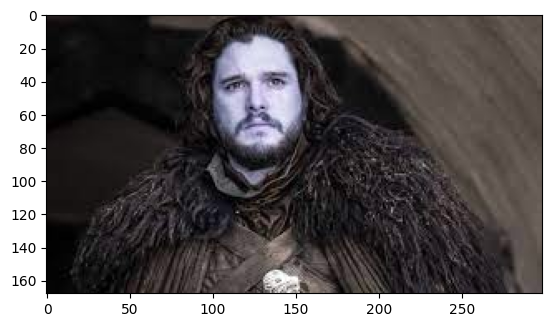

In [ ]:
test_img = cv2.imread('/content/snow.jpeg')
plt.imshow(test_img)
test_img.shape
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))
model.predict(test_input)

In [ ]:
predicted_class_index = np.argmax(model.predict(test_input), axis=-1)
predicted_class_name = label_encoder.classes_[predicted_class_index[0]]

print(predicted_class_name)

1/1 [==============================] - 0s 57ms/step
Predicted class: Sansa Stark


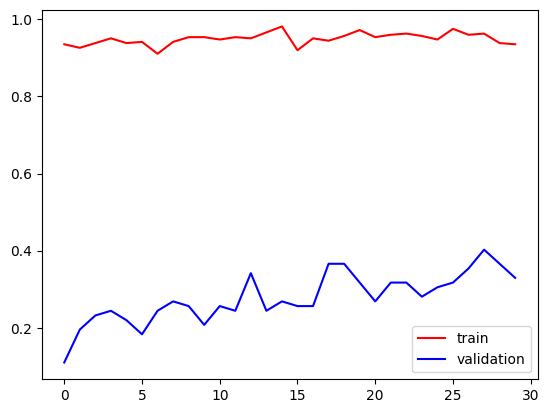

In [ ]:
plt.plot(history2.history['accuracy'],color='red',label='train')
plt.plot(history2.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()